# Lending Club Data Analysis

In [1]:
import os
from utils import utils as utils
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip freeze > ../../requirements.txt

## EDA

### Import Data & Quick Cleaning

In [ ]:
# path = Path.cwd().parent.parent
# data_path = path /'data'/'accepted_2007_to_2018Q4.csv'
# data = pd.read_csv(data_path)

In [ ]:
# # Drop cột policy code do chỉ có giá trị 1
# data = data.drop('policy_code', axis=1)

In [ ]:
# # issue_d (& others cols) NULL when ID is mapped and loan funded with other policy_code, since the dataset does not provide clients' policy code -> remove those rows
# data = data[data['issue_d'].isnull() == False]

In [ ]:
# # Remove 'Join App' rows and drop col 'application_type'
# data = data[data['application_type'] != 'Joint App']
# data = data.drop('application_type', axis=1)

## Flag GOOD/BAD on term = '36m' dataset

Dự kiến flag GOOD/BAD với dữ liệu lọc theo các trường 'initial_list_status', '_joint', 'term'

Trường 'initial_list_status' có 2 giá trị 'W' là whole funded (mua nợ 100% bởi các nhà đầu tư tổ chức) và 'W' là fractual funded (chia nhỏ khoản nợ cho nhiều nhà đầu tư nhỏ lẻ). Do không tìm được pattern riêng giữa 2 loại fund này nên sẽ đưa cả 2 loại vào xét GOOD/BAD.

Tách đôi bộ dữ liệu bởi trường 'term' do kỳ hạn khoản vay khác nhau có thể dẫn đến pattern trả nợ khác nhau

In [ ]:
# data_sorted = data[['initial_list_status', 'grade', 'funded_amnt_inv']].copy()
# grade_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
# data_sorted['grade'] = pd.Categorical(data_sorted['grade'], categories=grade_order, ordered=True)
# data_sorted = data_sorted.sort_values(by='grade')

# utils.plot_scatter(data_sorted, 'grade', 'funded_amnt_inv', 'initial_list_status')

### Split data by 'term'

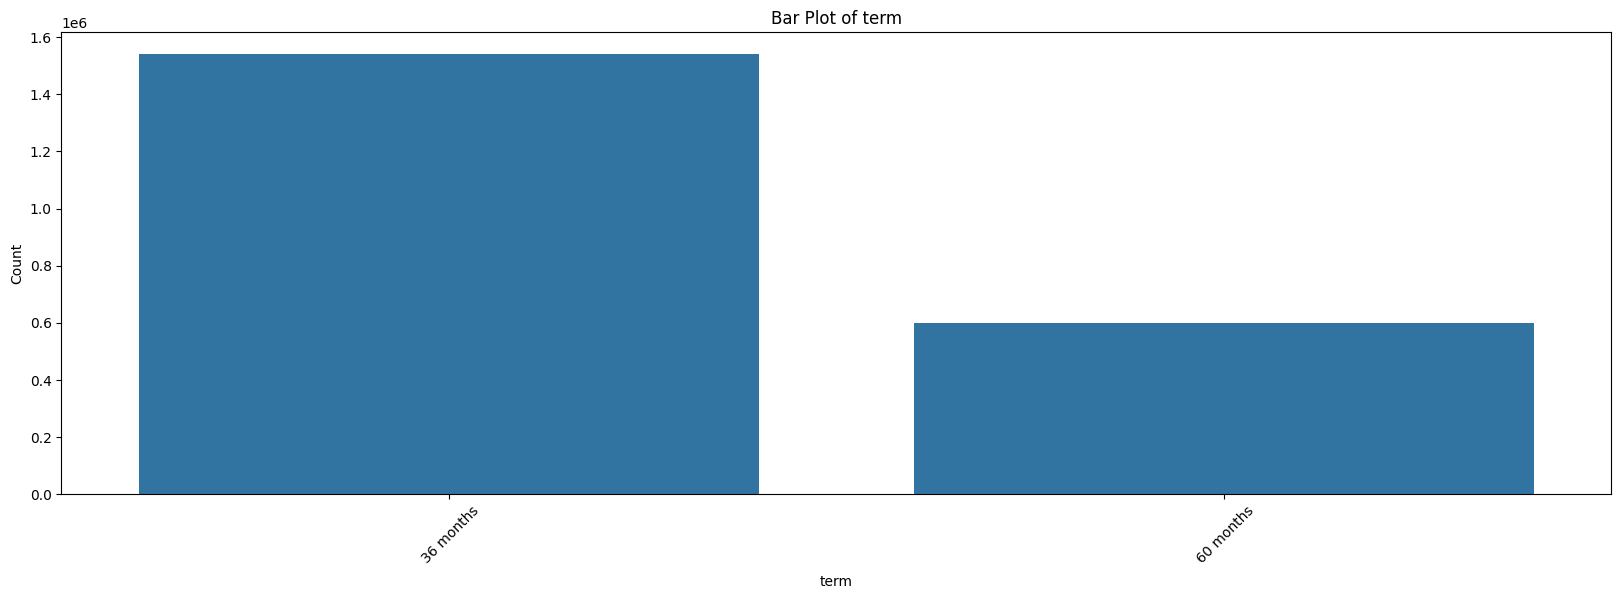

In [ ]:
# utils.plot_bar(data, 'term')

In [ ]:
# # Chia dữ liệu thành 2 bộ theo term 36m và term 60m
# data_36m = data[data['term'] == ' 36 months']
# data_60m = data[data['term'] == ' 60 months']

In [9]:
# data_36m.to_csv(str(path)+'\data\data_36m.csv')
# data_60m.to_csv(str(path)+'\data\data_60m.csv')

In [18]:
# # Checkpoint
path = Path.cwd().parent.parent
data_path = path /'data'/'data_36m.csv'
data_36m = pd.read_csv(data_path)

path = Path.cwd().parent.parent
data_path = path /'data'/'data_60m.csv'
data_60m = pd.read_csv(data_path)

### Plotting 'issue date'

In [19]:
# date_convert(loan_data, 'issue_d')
# date_convert(loan_data, 'earliest_cr_line')
# date_convert(loan_data, 'last_pymnt_d')
# date_convert(loan_data, 'last_credit_pull_d')
# date_convert(loan_data, 'next_pymnt_d')
data_36m['next_pymnt_d'] = pd.to_datetime(data_36m['next_pymnt_d'], format="%b-%Y")
data_36m['last_pymnt_d'] = pd.to_datetime(data_36m['last_pymnt_d'], format="%b-%Y")
data_36m['issue_d'] = pd.to_datetime(data_36m['issue_d'], format="%b-%Y")

In [20]:
data_36m = data_36m[data_36m['hardship_flag'] == 'N']

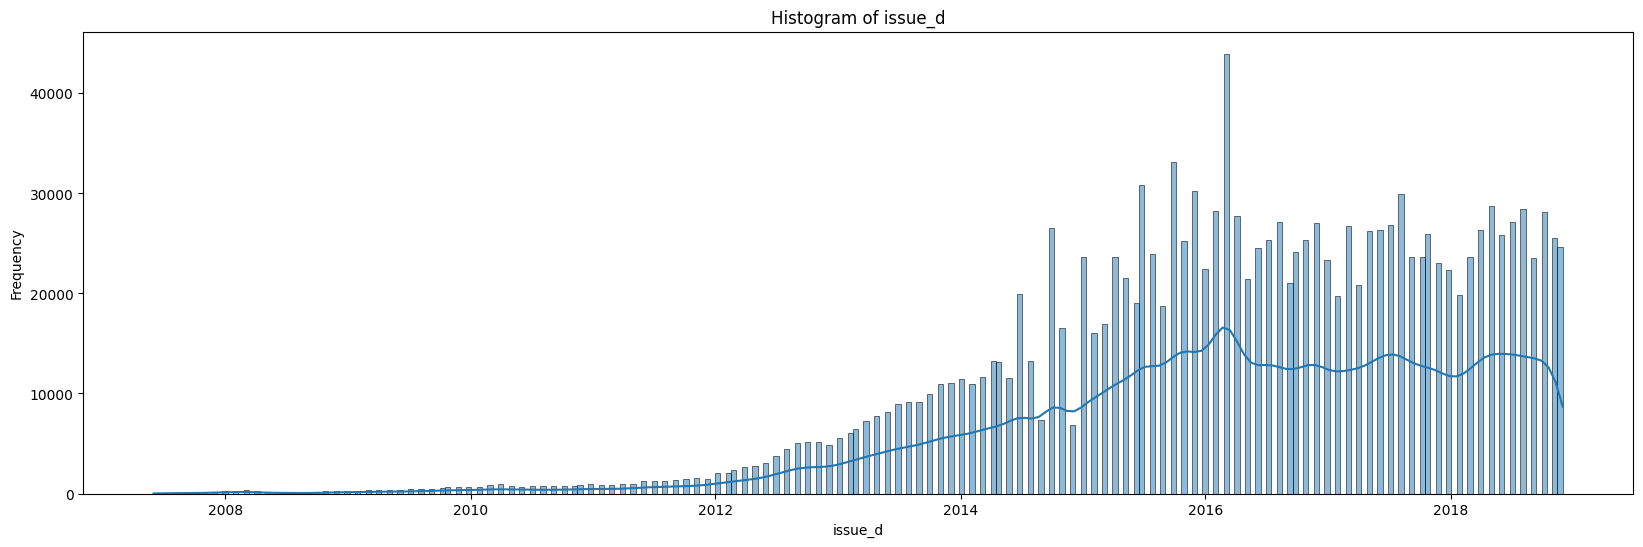

In [21]:
utils.plot_histogram(data_36m, 'issue_d')

### Plotting 'loan_status'

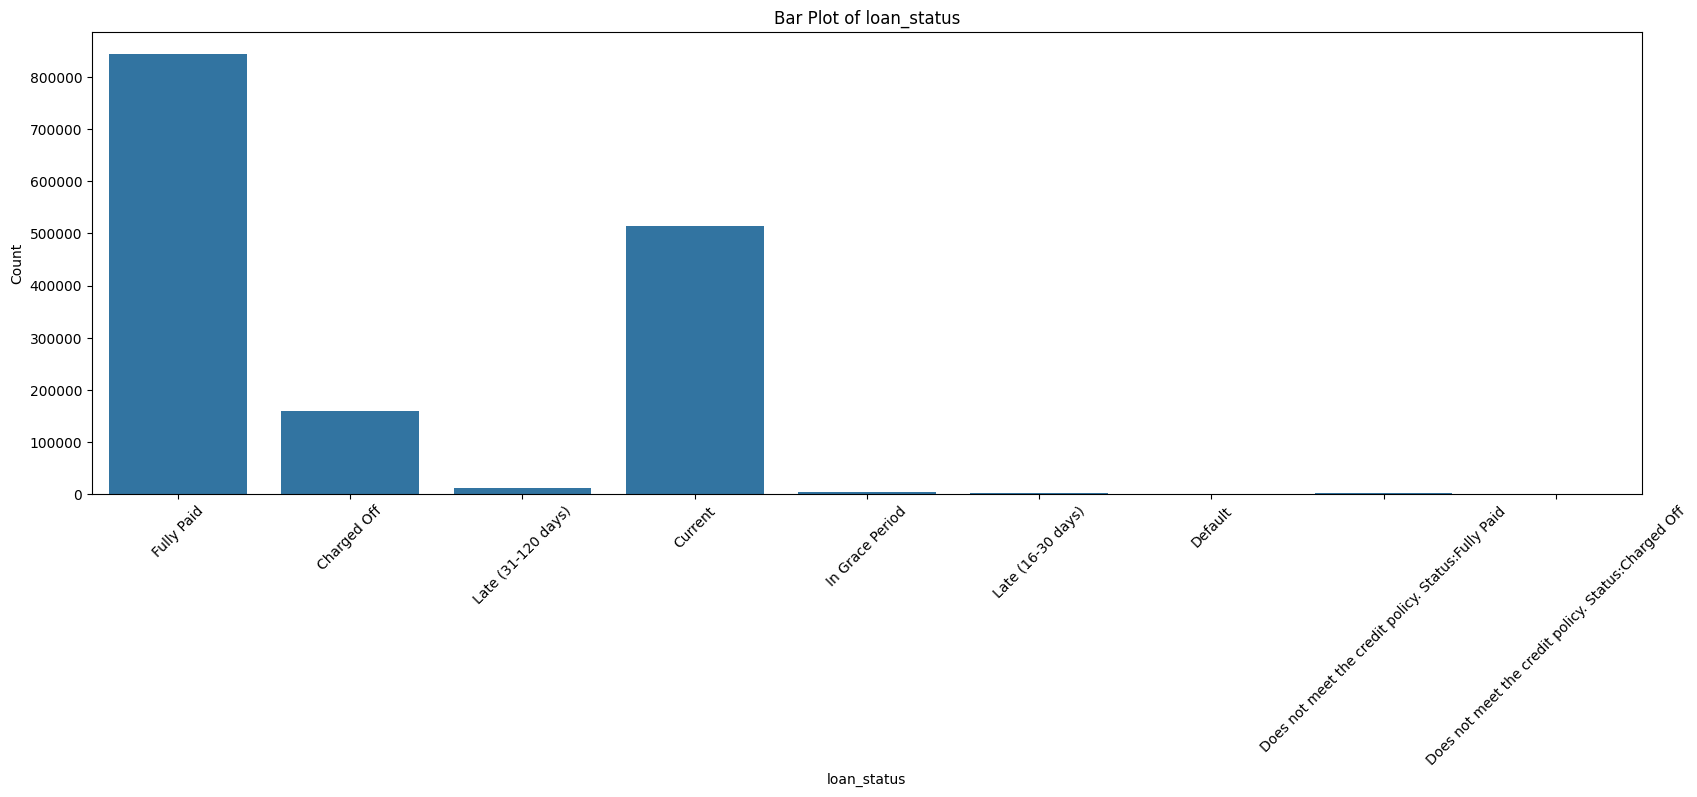

In [22]:
utils.plot_bar(data_36m, 'loan_status')

In [23]:
# Calculate how many time has clients paid their due?
data_36m['loan_age_years'] = ((data_36m['last_pymnt_d'] - data_36m['issue_d']))
data_36m['loan_age_years'] = data_36m['loan_age_years'].dt.days / 365 * 12

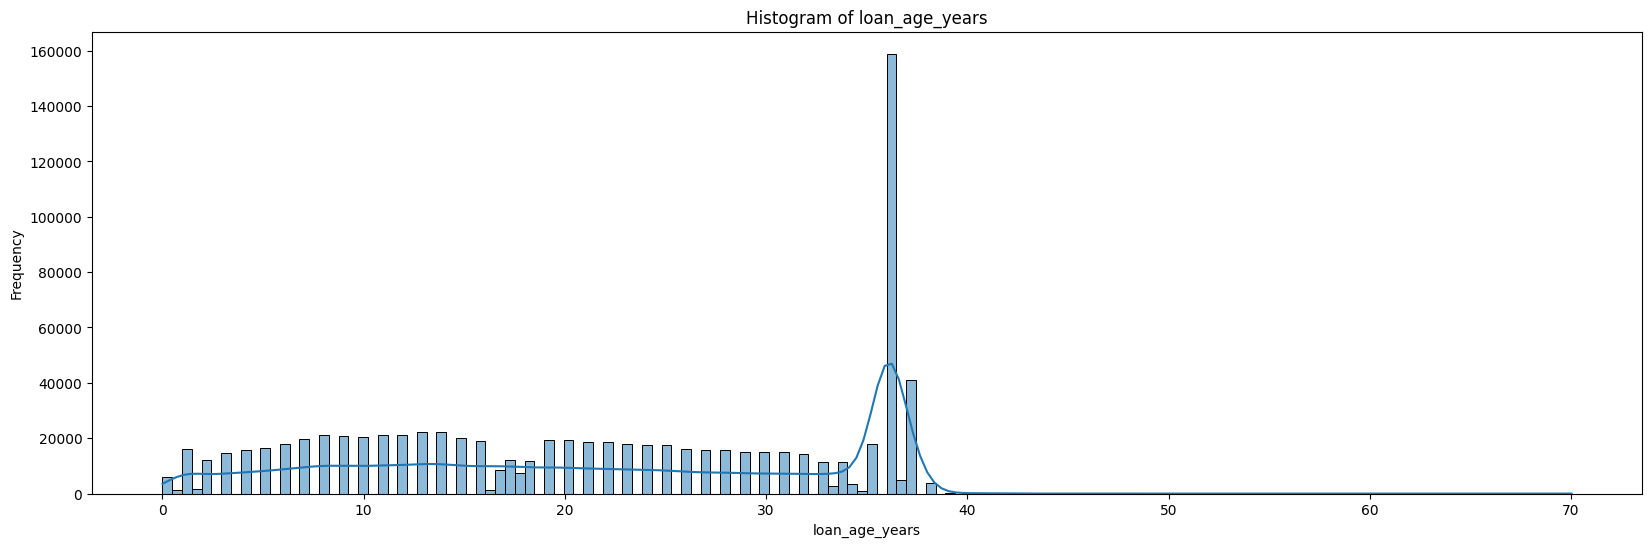

In [24]:
utils.plot_histogram(data_36m[data_36m['loan_status']=='Fully Paid'], 'loan_age_years')

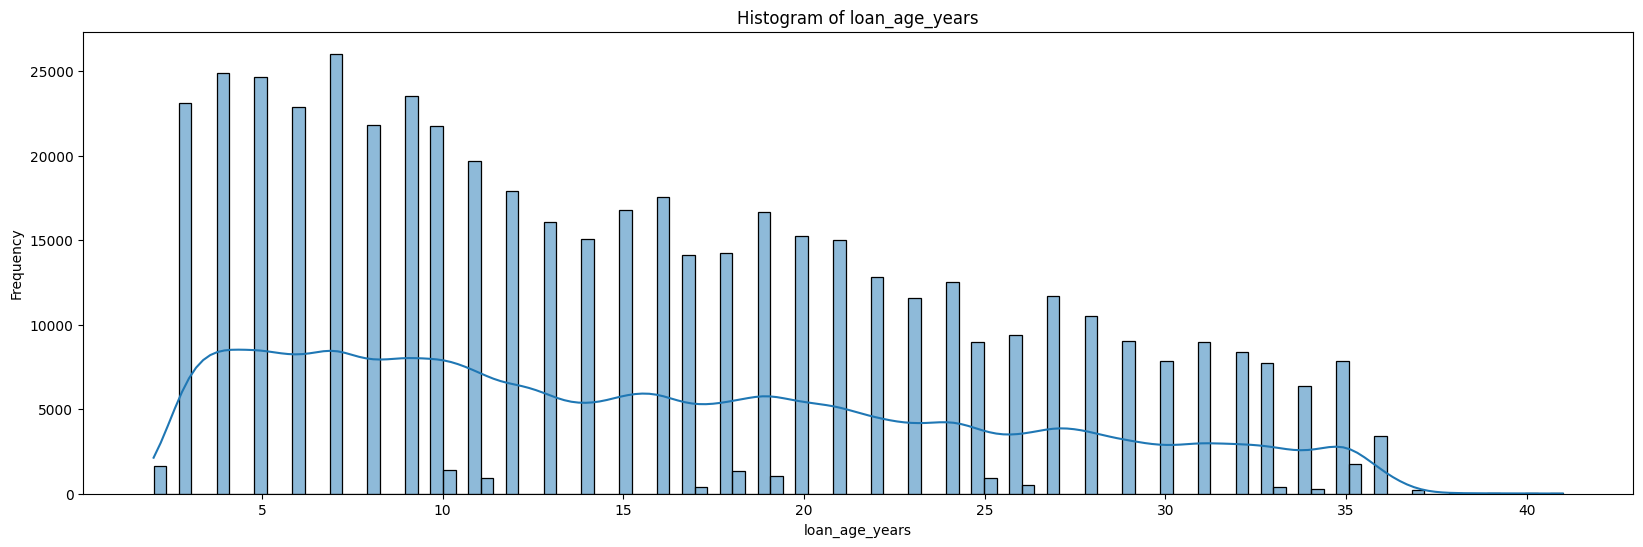

In [25]:
utils.plot_histogram(data_36m[data_36m['loan_status']=='Current'], 'loan_age_years')

Xuất hiện các trường hợp đặc thù, người trả đã Fully Paid nhưng thời gian trả lớn hơn 36 tháng, và những người đang trả Current nhưng thời gian trả cũng lớn hơn 36 tháng. Flag những trường hợp này là Undeterminated.

In [26]:
# Flag rows with loan_status = 'Fully Paid' and loan_age_years >= 37 as loan_status = 'Undeterminated'
data_36m.loc[(data_36m['loan_status'] == 'Fully Paid') & (data_36m['loan_age_years'] >= 37), 'loan_status'] = 'Undeterminated'
data_36m.loc[(data_36m['loan_status'] == 'Current') & (data_36m['loan_age_years'] >= 37), 'loan_status'] = 'Undeterminated'
# Flag rows with loan_status = 'Does not meet the credit policy. Status:Fully Paid', 'Does not meet the credit policy. Status:Charged Off' as 'Undeterminated'
# since I can't find the definition of credit policy in LendingClub docs
data_36m.loc[data_36m['loan_status'].isin(['Does not meet the credit policy. Status:Fully Paid', 'Does not meet the credit policy. Status:Charged Off']), 'loan_status'] = 'Undeterminated'

In [31]:
data_36m['loan_status'].unique()

array(['Undeterminated', 'Fully Paid', 'Charged Off',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Current', 'Default'], dtype=object)

In [36]:
# Cut data from M1/2015 to M12/2017
data_36m_bag = data_36m[(data_36m['issue_d'] >= '2015-01-01') & (data_36m['issue_d'] <= '2017-12-31')]
data_36m_oot = data_36m[data_36m['issue_d'] >= '2018-01-01']